# LSTM

Lstm은 RNN의 특별한 한 종류이다, 긴 의존 기간을 필요로 하는 학습을 수행할 능력을 갖고 있다.

# Kaggle 데이터를 활용하여 주가(삼성전자) 예측해보기

## (1) 라이브러리 생성

In [60]:
import numpy as np 
import pandas as pd 
import pandas_datareader.data as pdr 
import matplotlib.pyplot as plt 

import datetime 

import torch 
import torch.nn as nn 
from torch.autograd import Variable 

import torch.optim as optim
from torch.utils.data import Dataset, DataLoader



## (2) 삼성전자 주식 불러오기

In [62]:
df_price = pd.read_csv(os.path.join('/content/drive/MyDrive/01-삼성전자-주가.csv'), encoding='utf8')
df_price.describe()


,일자,시가,고가,저가,종가,거래량
count,9.288000e+03,9288.000000,9288.000000,9288.000000,9288.000000,9.288000e+03
mean,2.001347e+07,11108.556417,11228.754522,10986.106481,11108.235465,1.645823e+07
std,1.015376e+05,13792.646300,13920.105135,13658.809496,13790.922497,1.701535e+07
min,1.985010e+07,116.000000,116.000000,115.000000,116.000000,0.000000e+00
25%,1.992121e+07,624.000000,632.000000,620.000000,623.000000,3.833986e+06
50%,2.001032e+07,5045.000000,5190.000000,4955.000000,5075.000000,1.199608e+07
75%,2.010080e+07,15920.000000,16050.000000,15740.000000,15920.000000,2.284080e+07
max,2.020011e+07,57500.000000,57520.000000,56760.000000,57220.000000,3.266220e+08


컬럼[일자, 시가, 고가, 저가, 종가 , 거래량]으로 구성된 매우 단순한 데이터 셋이다. 총 9288개의 row로 구성되어 있는데 **[일자, 시가, 고가, 저가, 종가 , 거래량]** 을 토대로 미래의 주가인 종가를 예측해봅시다

## (3) 날짜 datetime 포멧으로 변환

In [63]:
pd.to_datetime(df_price['일자'], format='%Y%m%d')
# 0      2020-01-07
# 1      2020-01-06
# 2      2020-01-03
# 3      2020-01-02
# 4      2019-12-30

df_price['일자'] = pd.to_datetime(df_price['일자'], format='%Y%m%d')
df_price['연도'] =df_price['일자'].dt.year
df_price['월'] =df_price['일자'].dt.month
df_price['일'] =df_price['일자'].dt.day

/bin/bash: -c: line 0: syntax error near unexpected token `../../../Downloads/07-CHROME_DOWNLOAD_200213/0215-blog/stock-data-01.pngdf'
/bin/bash: -c: line 0: `[stock-data-01](../../../Downloads/07-CHROME_DOWNLOAD_200213/0215-blog/stock-data-01.pngdf = df_price.loc[df_price['연도']>=1990]'


Text(0, 0.5, 'price')

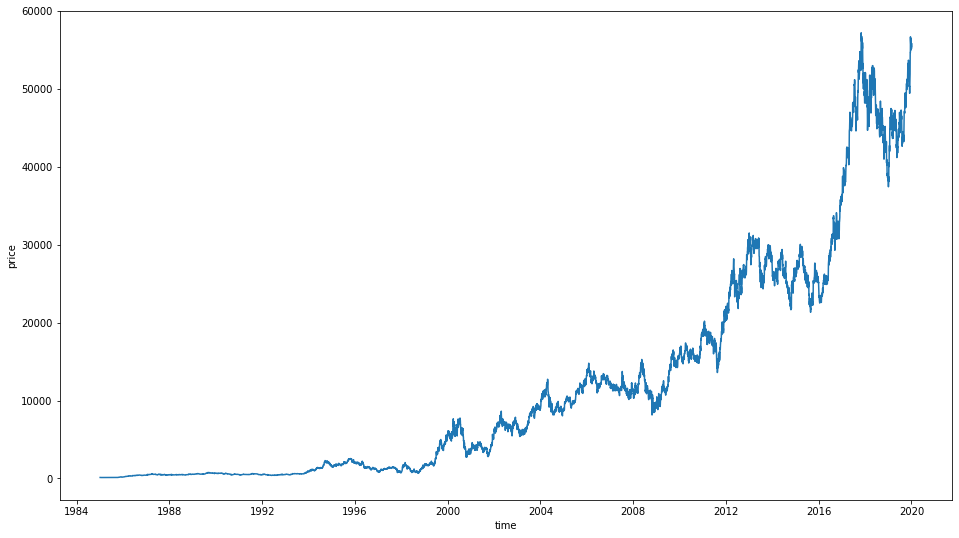

In [64]:
![stock-data-01](../../../Downloads/07-CHROME_DOWNLOAD_200213/0215-blog/stock-data-01.pngdf = df_price.loc[df_price['연도']>=1990]

plt.figure(figsize=(16, 9))
sns.lineplot(y=df_price['종가'], x=df_price['일자'])
plt.xlabel('time')
plt.ylabel('price')

## (4) Normalization

In [65]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scale_cols = ['시가', '고가', '저가', '종가', '거래량']
df_scaled = scaler.fit_transform(df_price[scale_cols])

df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols

print(df_scaled)

            시가        고가        저가        종가       거래량
0     0.968632  0.980489  0.979522  0.975133  0.030291
1     0.954691  0.966553  0.961868  0.969880  0.031470
2     0.973860  0.983973  0.967164  0.969880  0.047217
3     0.965147  0.973521  0.968929  0.964626  0.039781
4     0.977346  0.983973  0.981287  0.975133  0.025585
...        ...       ...       ...       ...       ...
9283  0.000174  0.000174  0.000124  0.000123  0.000995
9284  0.000227  0.000226  0.000212  0.000193  0.002587
9285  0.000227  0.000244  0.000229  0.000228  0.002363
9286  0.000227  0.000226  0.000229  0.000210  0.000332
9287  0.000244  0.000244  0.000247  0.000228  0.000342

[9288 rows x 5 columns]


In [66]:
TEST_SIZE = 200
train = df_scaled[:-TEST_SIZE]
test = df_scaled[-TEST_SIZE:]

In [67]:
def make_dataset(data, label, window_size=20):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [68]:
feature_cols = ['시가', '고가', '저가', '거래량']
label_cols = ['종가']

train_feature = train[feature_cols]
train_label = train[label_cols]

# train dataset
train_feature, train_label = make_dataset(train_feature, train_label, 20)

# train, validation set 생성
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2)

x_train.shape, x_valid.shape
# ((6086, 20, 4), (1522, 20, 4))

test_feature = test[feature_cols]
test_label = test[label_cols]
# test dataset (실제 예측 해볼 데이터)
test_feature, test_label = make_dataset(test_feature, test_label, 20)
test_feature.shape, test_label.shape
# ((180, 20, 4), (180, 1))

((180, 20, 4), (180, 1))

## (5) Keras를 활용한 LSTM 모델 생성

In [69]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(16, 
               input_shape=(train_feature.shape[1], train_feature.shape[2]), 
               activation='relu', 
               return_sequences=False)
          )
model.add(Dense(1))

In [70]:
model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='val_loss', patience=5)
filename = os.path.join('tmp_checkpoint.h5')
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history = model.fit(x_train, y_train, 
                    epochs=200, 
                    batch_size=16,
                    validation_data=(x_valid, y_valid), 
                    callbacks=[early_stop, checkpoint])

Epoch 1/200
454/454 [==============================] - 6s 8ms/step - loss: 0.0118 - val_loss: 8.1646e-05

Epoch 00001: val_loss improved from inf to 0.00008, saving model to tmp_checkpoint.h5
Epoch 2/200
454/454 [==============================] - 3s 7ms/step - loss: 8.7213e-05 - val_loss: 1.1699e-04

Epoch 00002: val_loss did not improve from 0.00008
Epoch 3/200
454/454 [==============================] - 3s 7ms/step - loss: 7.2637e-05 - val_loss: 5.1914e-05

Epoch 00003: val_loss improved from 0.00008 to 0.00005, saving model to tmp_checkpoint.h5
Epoch 4/200
454/454 [==============================] - 3s 7ms/step - loss: 6.4516e-05 - val_loss: 6.0082e-05

Epoch 00004: val_loss did not improve from 0.00005
Epoch 5/200
454/454 [==============================] - 3s 7ms/step - loss: 6.5145e-05 - val_loss: 7.4336e-05

Epoch 00005: val_loss did not improve from 0.00005
Epoch 6/200
454/454 [==============================] - 3s 7ms/step - loss: 6.4554e-05 - val_loss: 4.2353e-05

Epoch 00006: va

In [71]:
# weight 로딩
model.load_weights(filename)

# 예측
pred = model.predict(test_feature)

## (6) 실제데이터와 예측한 데이터 시각화

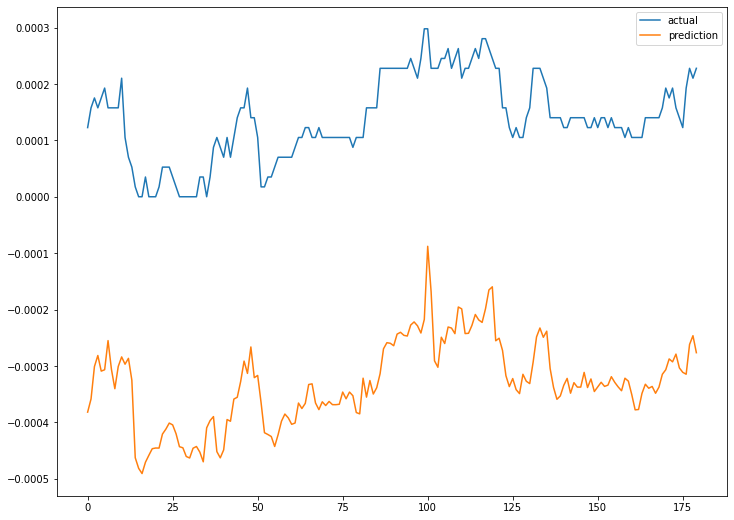

In [72]:
plt.figure(figsize=(12, 9))
plt.plot(test_label, label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()